In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
sns.set_style('darkgrid')

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(7)
limit_mem()

In [6]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [7]:
preddir = '/home/rasp/data/myWeatherBench/predictions_C/'
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [8]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
t2m_valid = xr.open_mfdataset(f'{valdir}2m_temperature/*.nc').sel(time=slice('2014', '2018', None))
tp_valid = xr.open_mfdataset(f'{valdir}6hr_precipitation/*.nc').sel(time=slice('2014', '2018', None))

valid = xr.merge([z500_valid, t850_valid, t2m_valid, tp_valid]).load()

In [9]:
valid = valid.isel(time=slice(0, None, 12))

In [10]:
rmse_baseline = read_pickle('./rmse.pkl')
acc_baseline = read_pickle('./acc.pkl')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc').rename({'z_rmse': "z", 't_rmse': 't'})

## get scores for direct predictions

### Saved predictions

In [187]:
def get_direct_scores_from_nc(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'{preddir}{exp_id}*.nc')[0]
        preds = xr.open_dataset(fn)
        scores.append(
            func(
                preds, 
                valid,
                mean_dims
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [188]:
rmse_direct_era = get_direct_scores_from_nc(['024', '029', '017', '032'], [6, 24, 72, 120])

In [189]:
rmse_direct_era.to_netcdf('./rmse_direct_era.nc')

In [190]:
rmse_direct_pre = get_direct_scores_from_nc(['026', '031', '023', '034'], [6, 24, 72, 120])

In [191]:
rmse_direct_pre.to_netcdf('./rmse_direct_pre.nc')

In [192]:
acc_direct_era = get_direct_scores_from_nc(['024', '029', '017', '032'], [6, 24, 72, 120], compute_weighted_acc)

In [193]:
acc_direct_era.to_netcdf('./acc_direct_era.nc')

In [194]:
acc_direct_pre = get_direct_scores_from_nc(['026', '031', '023', '034'], [6, 24, 72, 120], compute_weighted_acc)

In [195]:
acc_direct_pre.to_netcdf('./acc_direct_pre.nc')

#### Precip

In [196]:
rmse_tp_direct_era = get_direct_scores_from_nc(['048', '051', '054', '057'], [6, 24, 72, 120])

In [197]:
rmse_tp_direct_era.to_netcdf('./rmse_tp_direct_era.nc')

In [198]:
rmse_tp_direct_pre = get_direct_scores_from_nc(['050', '053', '056', '059'], [6, 24, 72, 120])

In [199]:
rmse_tp_direct_pre.to_netcdf('./rmse_tp_direct_pre.nc')

In [200]:
acc_tp_direct_era = get_direct_scores_from_nc(['048', '051', '054', '057'], [6, 24, 72, 120], compute_weighted_acc)

In [201]:
acc_tp_direct_era.to_netcdf('./acc_tp_direct_era.nc')

In [202]:
acc_tp_direct_pre = get_direct_scores_from_nc(['050', '053', '056', '059'], [6, 24, 72, 120], compute_weighted_acc)

In [203]:
acc_tp_direct_pre.to_netcdf('./acc_tp_direct_pre.nc')

### CMIP test scores

In [20]:
def get_direct_scores_from_dg(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS, 
                              train_years=['2014', '2015'], split='train', cmip_exp_ids=None):
    scores = []
    for i, exp_id in tqdm(enumerate(exp_ids)):
        fn = glob(f'../nn_configs/C/{exp_id}*.yml')[0]
        args = load_args(fn)
        if not cmip_exp_ids is None:
            fn_cmip = glob(f'../nn_configs/C/{cmip_exp_ids[i]}*.yml')[0]
            args_cmip = load_args(fn_cmip)
            model = keras.models.load_model(
                f"{args_cmip['model_save_dir']}/{args_cmip['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse, 'ChannelReLU2D': ChannelReLU2D}
            )
        else: 
            model = keras.models.load_model(
                f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse, 'ChannelReLU2D': ChannelReLU2D}
            )
        print(model.summary())
        mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
        std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
        args['ext_mean'] = mean
        args['ext_std'] = std
        args['train_years'] = train_years
        args['train_tfr_files'] = None
        args['valid_tfr_files'] = None
        args['test_tfr_files'] = None
        print('Load data')
        if split == 'train':
            dg_train, dg_valid, dg_test = load_data(**args)
            dg_train.shuffle = False; dg_train.on_epoch_end()
            dg = dg_train
        elif split == 'test':
            dg_test = load_data(**args, only_test=True)
            dg = dg_test


        preds = create_predictions(model, dg, verbose=1)
        save_fn = f"{args['pred_save_dir']}/{args['exp_id']}_{split}{'_cmip' if not cmip_exp_ids is None else ''}.nc"
        print(f'Saving predictions: {save_fn}')
        preds.to_netcdf(save_fn)
        scores.append(
            func(
                preds, 
                valid
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [213]:
rmse_direct_cmip_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120], cmip_exp_ids=['025', '030', '020', '033'], split='test'
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

547/547 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (No

547/547 [==============================] - 55s 100ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (No

545/545 [==============================] - 50s 93ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (Non

544/544 [==============================] - 54s 98ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//032-resnet_d3_ztt_5d_test_cmip.nc



In [214]:
rmse_direct_cmip_train.to_netcdf('rmse_direct_cmip_train.nc')

In [21]:
acc_direct_cmip_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120], cmip_exp_ids=['025', '030', '020', '033'], split='test',
    func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

547/547 [==============================] - 56s 102ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (No

547/547 [==============================] - 56s 102ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (No

545/545 [==============================] - 57s 105ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (No

544/544 [==============================] - 57s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//032-resnet_d3_ztt_5d_test_cmip.nc



In [22]:
acc_direct_cmip_train.to_netcdf('acc_direct_cmip_train.nc')

#### Precip

In [ ]:
rmse_tp_direct_cmip_train = get_direct_scores_from_dg(
    ['048', '051', '054', '057'], [6, 24, 72, 120], cmip_exp_ids=['049', '052', '055', '058'], split='test'
)

In [ ]:
rmse_tp_direct_cmip_train.to_netcdf('rmse_tp_direct_cmip_train.nc')

In [23]:
acc_tp_direct_cmip_train = get_direct_scores_from_dg(
    ['048', '051', '054', '057'], [6, 24, 72, 120], cmip_exp_ids=['049', '052', '055', '058'], split='test',
    func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

547/547 [==============================] - 56s 101ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//048-resnet_d3_tp_6h_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (Non

547/547 [==============================] - 55s 100ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//051-resnet_d3_tp_1d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (Non

545/545 [==============================] - 54s 98ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//054-resnet_d3_tp_3d_test_cmip.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None

544/544 [==============================] - 55s 102ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//057-resnet_d3_tp_5d_test_cmip.nc



In [24]:
acc_tp_direct_cmip_train.to_netcdf('acc_tp_direct_cmip_train.nc')

### Train scores

In [13]:
rmse_direct_era_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120]
)

Load data
DG start 14:07:27.485850
DG normalize 14:07:27.536546
DG load 14:07:27.547180
Loading data into RAM
DG done 14:09:41.213215
547/547 [==============================] - 134s 246ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_train.nc
Load data
DG start 14:16:39.262097
DG normalize 14:16:39.306537
DG load 14:16:39.315739
Loading data into RAM
DG done 14:29:42.161682
546/546 [==============================] - 73s 134ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_train.nc
Load data
DG start 14:44:40.572698
DG normalize 14:44:40.634487
DG load 14:44:40.646840
Loading data into RAM
DG done 14:53:57.800842
545/545 [==============================] - 184s 337ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_train.nc
Load data
DG start 15:07:11.630531
DG normalize 15:07:11.767186
DG load 15:07:12.024998
Loading data into RAM
DG done 15:18:10.196533


In [14]:
rmse_direct_era_train.to_netcdf('rmse_direct_era_train.nc')

In [15]:
rmse_direct_pre_train = get_direct_scores_from_dg(
    ['026', '031', '023', '034'], [6, 24, 72, 120]
)

Load data
DG start 15:29:14.623211
DG normalize 15:29:14.670553
DG load 15:29:14.681267
Loading data into RAM
DG done 15:36:55.245178
547/547 [==============================] - 70s 129ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//026-resnet_d3_ztt_6h_pre_no_dr_train.nc
Load data
DG start 15:52:36.907962
DG normalize 15:52:36.975051
DG load 15:52:36.987491
Loading data into RAM
DG done 16:09:21.925564
546/546 [==============================] - 60s 110ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//031-resnet_d3_ztt_1d_pre_no_dr_train.nc
Load data
DG start 16:21:18.465026
DG normalize 16:21:18.510695
DG load 16:21:18.518757
Loading data into RAM
DG done 16:21:43.576370
545/545 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//023-resnet_d3_ztt_3d_pre_no_dr_train.nc
Load data
DG start 16:28:18.702375
DG normalize 16:28:18.748018
DG load 16:28:18.756118
Loading data into 

In [16]:
rmse_direct_pre_train.to_netcdf('rmse_direct_pre_train.nc')

In [42]:
acc_direct_era_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120], func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 13:28:19.231690
DG normalize 13:28:19.276368
DG load 13:28:19.286881
Loading data into RAM
DG done 13:28:39.243041
547/547 [==============================] - 57s 105ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
______________

DG start 13:30:16.627658
DG normalize 13:30:16.675905
DG load 13:30:16.689394
Loading data into RAM
DG done 13:30:33.363578
546/546 [==============================] - 58s 107ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
______________

DG start 13:32:13.838362
DG normalize 13:32:13.888033
DG load 13:32:13.899042
Loading data into RAM
DG done 13:32:34.400024
545/545 [==============================] - 54s 99ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 13:34:10.298633
DG normalize 13:34:10.345421
DG load 13:34:10.356472
Loading data into RAM
DG done 13:34:27.520069
543/543 [==============================] - 59s 109ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//032-resnet_d3_ztt_5d_train.nc



In [43]:
acc_direct_era_train.to_netcdf('acc_direct_era_train.nc')

In [44]:
acc_direct_pre_train = get_direct_scores_from_dg(
    ['026', '031', '023', '034'], [6, 24, 72, 120], func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 13:36:05.977072
DG normalize 13:36:06.025699
DG load 13:36:06.036194
Loading data into RAM
DG done 13:36:22.657370
547/547 [==============================] - 56s 103ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//026-resnet_d3_ztt_6h_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
____

DG start 13:37:59.943289
DG normalize 13:37:59.992436
DG load 13:38:00.003704
Loading data into RAM
DG done 13:38:17.080438
546/546 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//031-resnet_d3_ztt_1d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
____

DG start 13:39:56.892649
DG normalize 13:39:56.941026
DG load 13:39:56.952119
Loading data into RAM
DG done 13:40:14.084825
545/545 [==============================] - 62s 113ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//023-resnet_d3_ztt_3d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
____

DG start 13:41:56.407925
DG normalize 13:41:56.454063
DG load 13:41:56.465504
Loading data into RAM
DG done 13:42:11.767724
543/543 [==============================] - 63s 116ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//034-resnet_d3_ztt_5d_pre_no_dr_train.nc



In [45]:
acc_direct_pre_train.to_netcdf('acc_direct_pre_train.nc')

#### Precip

In [46]:
rmse_tp_direct_era_train = get_direct_scores_from_dg(
    ['048', '051', '054', '057'], [6, 24, 72, 120]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 13:43:53.366764
DG normalize 13:43:53.416721
DG load 13:43:53.427579
Loading data into RAM
DG done 13:44:08.932679
547/547 [==============================] - 57s 105ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//048-resnet_d3_tp_6h_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 13:45:39.845098
DG normalize 13:45:39.893697
DG load 13:45:39.904121
Loading data into RAM
DG done 13:45:57.830496
546/546 [==============================] - 57s 104ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//051-resnet_d3_tp_1d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 13:47:34.566006
DG normalize 13:47:34.615831
DG load 13:47:34.627439
Loading data into RAM
DG done 13:47:50.081471
545/545 [==============================] - 60s 110ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//054-resnet_d3_tp_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 13:49:28.786099
DG normalize 13:49:28.832952
DG load 13:49:28.844267
Loading data into RAM
DG done 13:49:44.377492
543/543 [==============================] - 60s 111ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//057-resnet_d3_tp_5d_train.nc



In [47]:
rmse_tp_direct_era_train.to_netcdf('rmse_tp_direct_era_train.nc')

In [48]:
rmse_tp_direct_pre_train = get_direct_scores_from_dg(
    ['050', '053', '056', '059'], [6, 24, 72, 120]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 13:51:30.372615
DG normalize 13:51:30.422767
DG load 13:51:30.434057
Loading data into RAM
DG done 13:51:46.590276
547/547 [==============================] - 60s 110ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//050-resnet_d3_tp_6h_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 13:53:23.075639
DG normalize 13:53:23.124815
DG load 13:53:23.134968
Loading data into RAM
DG done 13:53:56.669878
546/546 [==============================] - 61s 111ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//053-resnet_d3_tp_1d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 13:59:41.207578
DG normalize 13:59:41.256425
DG load 13:59:41.267031
Loading data into RAM
DG done 14:00:00.553640
545/545 [==============================] - 63s 116ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//056-resnet_d3_tp_3d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 14:07:46.717120
DG normalize 14:07:46.765434
DG load 14:07:46.777335
Loading data into RAM
DG done 14:10:10.039099
543/543 [==============================] - 64s 118ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//059-resnet_d3_tp_5d_pre_no_dr_train.nc



In [49]:
rmse_tp_direct_pre_train.to_netcdf('rmse_tp_direct_pre_train.nc')

In [50]:
acc_tp_direct_era_train = get_direct_scores_from_dg(
    ['048', '051', '054', '057'], [6, 24, 72, 120], func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 14:20:46.682654
DG normalize 14:20:46.734695
DG load 14:20:46.748654
Loading data into RAM
DG done 14:22:35.760895
547/547 [==============================] - 61s 112ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//048-resnet_d3_tp_6h_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 14:33:41.671333
DG normalize 14:33:41.718889
DG load 14:33:41.731229
Loading data into RAM
DG done 14:47:24.828604
546/546 [==============================] - 65s 118ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//051-resnet_d3_tp_1d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 15:04:40.625667
DG normalize 15:04:40.670189
DG load 15:04:40.680567
Loading data into RAM
DG done 15:05:23.021024
545/545 [==============================] - 62s 114ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//054-resnet_d3_tp_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_______________

DG start 15:07:27.150728
DG normalize 15:07:27.199104
DG load 15:07:27.208902
Loading data into RAM
DG done 15:07:45.002713
543/543 [==============================] - 57s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//057-resnet_d3_tp_5d_train.nc



In [51]:
acc_tp_direct_era_train.to_netcdf('acc_tp_direct_era_train.nc')

In [52]:
acc_tp_direct_pre_train = get_direct_scores_from_dg(
    ['050', '053', '056', '059'], [6, 24, 72, 120], func=compute_weighted_acc
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 15:09:32.282130
DG normalize 15:09:32.330782
DG load 15:09:32.341637
Loading data into RAM
DG done 15:09:48.104598
547/547 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//050-resnet_d3_tp_6h_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 15:11:22.552812
DG normalize 15:11:22.598889
DG load 15:11:22.609382
Loading data into RAM
DG done 15:11:43.169785
546/546 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//053-resnet_d3_tp_1d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 15:18:41.467575
DG normalize 15:18:41.515895
DG load 15:18:41.526252
Loading data into RAM
DG done 15:18:57.263550
545/545 [==============================] - 62s 114ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//056-resnet_d3_tp_3d_pre_no_dr_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
_____

DG start 15:27:25.612618
DG normalize 15:27:25.661719
DG load 15:27:25.671101
Loading data into RAM
DG done 15:30:51.816942
543/543 [==============================] - 58s 107ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//059-resnet_d3_tp_5d_pre_no_dr_train.nc



In [53]:
acc_tp_direct_pre_train.to_netcdf('acc_tp_direct_pre_train.nc')

## get scores for contiuous

In [11]:
def get_cont_scores(exp_id, lead_times, func=compute_weighted_rmse, train_years=['2014', '2015'], split='test',
                    cmip_exp_id=None):
    lead_times = xr.DataArray(lead_times, dims={'lead_time': lead_times}, name='lead_time')
    fn = glob(f'../nn_configs/C/{exp_id}*.yml')[0]
    args = load_args(fn)
    args['train_tfr_files'] = None
    args['valid_tfr_files'] = None
    args['test_tfr_files'] = None
    if not cmip_exp_id is None:
            fn_cmip = glob(f'../nn_configs/C/{cmip_exp_id}*.yml')[0]
            args_cmip = load_args(fn_cmip)
            model = keras.models.load_model(
                f"{args_cmip['model_save_dir']}/{args_cmip['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse, 'ChannelReLU2D': ChannelReLU2D}
            )
    else:
        model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse, 'ChannelReLU2D': ChannelReLU2D})
    
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    args['train_years'] = train_years
    
    if split == 'train':
        dg, _, _ = load_data(**args)
        dg.shuffle = False; dg.on_epoch_end(); 
    else:
        dg = load_data(**args, only_test=True)
    dg.fixed_time = True
    preds = []
    for l in tqdm(lead_times):
        dg.lead_time = l.values; dg.on_epoch_end()
        p = create_predictions(model, dg, verbose=1)
        p['time'] = dg.init_time
        preds.append(p)
    preds = xr.concat(preds, lead_times)
    save_fn = f"{args['pred_save_dir']}/{args['exp_id']}_{split}{'_cmip' if not cmip_exp_ids is None else ''}.nc"
    print(f'Saving predictions: {save_fn}')
    preds.to_netcdf(save_fn)
    return evaluate_iterative_forecast(preds, valid, func)

In [229]:
rmse_cont_era = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120])

544/544 [==============================] - 67s 123ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_test.nc


In [230]:
rmse_cont_era.to_netcdf('./rmse_cont_era.nc')

In [231]:
rmse_cont_era_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='train')

DG start 11:39:31.005877
DG normalize 11:39:31.050011
DG load 11:39:31.057812
Loading data into RAM
DG done 11:39:46.504049


543/543 [==============================] - 67s 124ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_train.nc


In [232]:
rmse_cont_era_train.to_netcdf('./rmse_cont_era_train.nc')

In [233]:
rmse_cont_cmip_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='test', cmip_exp_id='036')

544/544 [==============================] - 73s 134ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_test.nc


In [234]:
rmse_cont_cmip_train.to_netcdf('./rmse_cont_cmip_train.nc')

In [235]:
rmse_cont_pre = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120])

544/544 [==============================] - 85s 156ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//037-resnet_d3_ztt_cont_pre_no_dr_test.nc


In [236]:
rmse_cont_pre.to_netcdf('./rmse_cont_pre.nc')

In [237]:
rmse_cont_pre_train = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120], split='train')

DG start 12:08:56.083861
DG normalize 12:08:56.129522
DG load 12:08:56.138021
Loading data into RAM
DG done 12:09:17.157863


543/543 [==============================] - 70s 128ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//037-resnet_d3_ztt_cont_pre_no_dr_train.nc


In [238]:
rmse_cont_pre_train.to_netcdf('./rmse_cont_pre_train.nc')

In [55]:
acc_cont_era = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], func=compute_weighted_acc)

544/544 [==============================] - 69s 126ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_test.nc


In [56]:
acc_cont_era.to_netcdf('./acc_cont_era.nc')

In [57]:
acc_cont_era_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='train', func=compute_weighted_acc)

DG start 16:42:02.937677
DG normalize 16:42:02.985885
DG load 16:42:03.005547
Loading data into RAM
DG done 16:42:19.605079


543/543 [==============================] - 66s 121ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_train.nc


In [58]:
acc_cont_era_train.to_netcdf('./acc_cont_era_train.nc')

In [59]:
acc_cont_cmip_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='test', cmip_exp_id='036', func=compute_weighted_acc)

544/544 [==============================] - 77s 141ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_test.nc


In [60]:
acc_cont_cmip_train.to_netcdf('./acc_cont_cmip_train.nc')

In [61]:
acc_cont_pre = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120], func=compute_weighted_acc)

544/544 [==============================] - 76s 140ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//037-resnet_d3_ztt_cont_pre_no_dr_test.nc


In [62]:
acc_cont_pre.to_netcdf('./acc_cont_pre.nc')

In [63]:
acc_cont_pre_train = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120], split='train', func=compute_weighted_acc)

DG start 17:17:32.471776
DG normalize 17:17:32.513638
DG load 17:17:32.521865
Loading data into RAM
DG done 17:20:38.290852


543/543 [==============================] - 78s 143ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//037-resnet_d3_ztt_cont_pre_no_dr_train.nc


In [64]:
acc_cont_pre_train.to_netcdf('./acc_cont_pre_train.nc')

#### Precip

In [242]:
rmse_tp_cont_era = get_cont_scores('072', [6, 12, 24, 48, 72, 96, 120])

544/544 [==============================] - 66s 122ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_test.nc


In [243]:
rmse_tp_cont_era.to_netcdf('./rmse_tp_cont_era.nc')

In [244]:
rmse_tp_cont_era_train = get_cont_scores('072', [6, 12, 24, 48, 72, 96, 120], split='train')

DG start 12:51:15.003718
DG normalize 12:51:15.049526
DG load 12:51:15.058014
Loading data into RAM
DG done 12:51:30.751856


543/543 [==============================] - 65s 120ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_train.nc


In [245]:
rmse_tp_cont_era_train.to_netcdf('./rmse_tp_cont_era_train.nc')

In [246]:
rmse_tp_cont_cmip_train = get_cont_scores('072', [6, 12, 24, 48, 72, 96, 120], split='test', cmip_exp_id='073')

544/544 [==============================] - 63s 117ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_test.nc


In [247]:
rmse_tp_cont_cmip_train.to_netcdf('./rmse_tp_cont_cmip_train.nc')

In [248]:
rmse_tp_cont_pre = get_cont_scores('074', [6, 12, 24, 48, 72, 96, 120])

544/544 [==============================] - 67s 122ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//074-resnet_d3_tp_cont_pre_no_dr_test.nc


In [249]:
rmse_tp_cont_pre.to_netcdf('./rmse_tp_cont_pre.nc')

In [250]:
rmse_tp_cont_pre_train = get_cont_scores('074', [6, 12, 24, 48, 72, 96, 120], split='train')

DG start 13:17:22.534267
DG normalize 13:17:22.580949
DG load 13:17:22.589447
Loading data into RAM
DG done 13:17:37.689571


543/543 [==============================] - 66s 121ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//074-resnet_d3_tp_cont_pre_no_dr_train.nc


In [251]:
rmse_tp_cont_pre_train.to_netcdf('./rmse_tp_cont_pre_train.nc')

In [252]:
acc_tp_cont_era = get_cont_scores('072', [6, 12, 24, 48, 72, 96, 120], func=compute_weighted_acc)

544/544 [==============================] - 61s 112ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_test.nc


In [253]:
acc_tp_cont_era.to_netcdf('./acc_tp_cont_era.nc')

In [254]:
acc_tp_cont_era_train = evaluate_iterative_forecast(
    xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_train.nc'), 
    valid, compute_weighted_acc
)

In [255]:
acc_tp_cont_era_train.to_netcdf('./acc_tp_cont_era_train.nc')

In [256]:
acc_tp_cont_cmip_train = evaluate_iterative_forecast(
    xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C//072-resnet_d3_tp_cont_test.nc'), 
    valid, compute_weighted_acc
)

In [257]:
acc_tp_cont_cmip_train.to_netcdf('./acc_tp_cont_cmip_train.nc')

In [258]:
acc_tp_cont_pre = evaluate_iterative_forecast(
    xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C//074-resnet_d3_tp_cont_pre_no_dr_test.nc'), 
    valid, compute_weighted_acc
)

In [259]:
acc_tp_cont_pre.to_netcdf('./acc_tp_cont_pre.nc')

In [260]:
acc_tp_cont_pre_train = evaluate_iterative_forecast(
    xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C//074-resnet_d3_tp_cont_pre_no_dr_train.nc'), 
    valid, compute_weighted_acc
)

In [261]:
acc_tp_cont_pre_train.to_netcdf('./acc_tp_cont_pre_train.nc')

## Plot scores

### Load all data

In [11]:
rmse_direct_era = xr.open_dataset('rmse_direct_era.nc')
rmse_direct_era_train = xr.open_dataset('rmse_direct_era_train.nc')
rmse_direct_pre = xr.open_dataset('rmse_direct_pre.nc')
rmse_direct_pre_train = xr.open_dataset('rmse_direct_pre_train.nc')
rmse_direct_cmip_train = xr.open_dataset('rmse_direct_cmip_train.nc')

In [12]:
acc_direct_era = xr.open_dataset('acc_direct_era.nc')
acc_direct_era_train = xr.open_dataset('acc_direct_era_train.nc')
acc_direct_pre = xr.open_dataset('acc_direct_pre.nc')
acc_direct_pre_train = xr.open_dataset('acc_direct_pre_train.nc')
acc_direct_cmip_train = xr.open_dataset('acc_direct_cmip_train.nc')

In [13]:
rmse_cont_era = xr.open_dataset('rmse_cont_era.nc')
rmse_cont_era_train = xr.open_dataset('rmse_cont_era_train.nc')
rmse_cont_pre = xr.open_dataset('rmse_cont_pre.nc')
rmse_cont_pre_train = xr.open_dataset('rmse_cont_pre_train.nc')
rmse_cont_cmip_train = xr.open_dataset('rmse_cont_cmip_train.nc')

In [14]:
acc_cont_era = xr.open_dataset('acc_cont_era.nc')
acc_cont_era_train = xr.open_dataset('acc_cont_era_train.nc')
acc_cont_pre = xr.open_dataset('acc_cont_pre.nc')
acc_cont_pre_train = xr.open_dataset('acc_cont_pre_train.nc')
acc_cont_cmip_train = xr.open_dataset('acc_cont_cmip_train.nc')

In [15]:
rmse_tp_direct_era = xr.open_dataset('rmse_tp_direct_era.nc')
rmse_tp_direct_era_train = xr.open_dataset('rmse_tp_direct_era_train.nc')
rmse_tp_direct_pre = xr.open_dataset('rmse_tp_direct_pre.nc')
rmse_tp_direct_pre_train = xr.open_dataset('rmse_tp_direct_pre_train.nc')
rmse_tp_direct_cmip_train = xr.open_dataset('rmse_tp_direct_cmip_train.nc')

In [16]:
acc_tp_direct_era = xr.open_dataset('acc_tp_direct_era.nc')
acc_tp_direct_era_train = xr.open_dataset('acc_tp_direct_era_train.nc')
acc_tp_direct_pre = xr.open_dataset('acc_tp_direct_pre.nc')
acc_tp_direct_pre_train = xr.open_dataset('acc_tp_direct_pre_train.nc')
acc_tp_direct_cmip_train = xr.open_dataset('acc_tp_direct_cmip_train.nc')

In [17]:
rmse_tp_cont_era = xr.open_dataset('rmse_tp_cont_era.nc')
rmse_tp_cont_era_train = xr.open_dataset('rmse_tp_cont_era_train.nc')
rmse_tp_cont_pre = xr.open_dataset('rmse_tp_cont_pre.nc')
rmse_tp_cont_pre_train = xr.open_dataset('rmse_tp_cont_pre_train.nc')
rmse_tp_cont_cmip_train = xr.open_dataset('rmse_tp_cont_cmip_train.nc')

In [18]:
acc_tp_cont_era = xr.open_dataset('acc_tp_cont_era.nc')
acc_tp_cont_era_train = xr.open_dataset('acc_tp_cont_era_train.nc')
acc_tp_cont_pre = xr.open_dataset('acc_tp_cont_pre.nc')
acc_tp_cont_pre_train = xr.open_dataset('acc_tp_cont_pre_train.nc')
acc_tp_cont_cmip_train = xr.open_dataset('acc_tp_cont_cmip_train.nc')

### Plot

In [19]:
def plot_zt(ds, label, **kwargs):
    ds.z.plot(ax=ax1, label=label, lw=2, **kwargs)
    ds.t.plot(ax=ax2, lw=2, **kwargs)

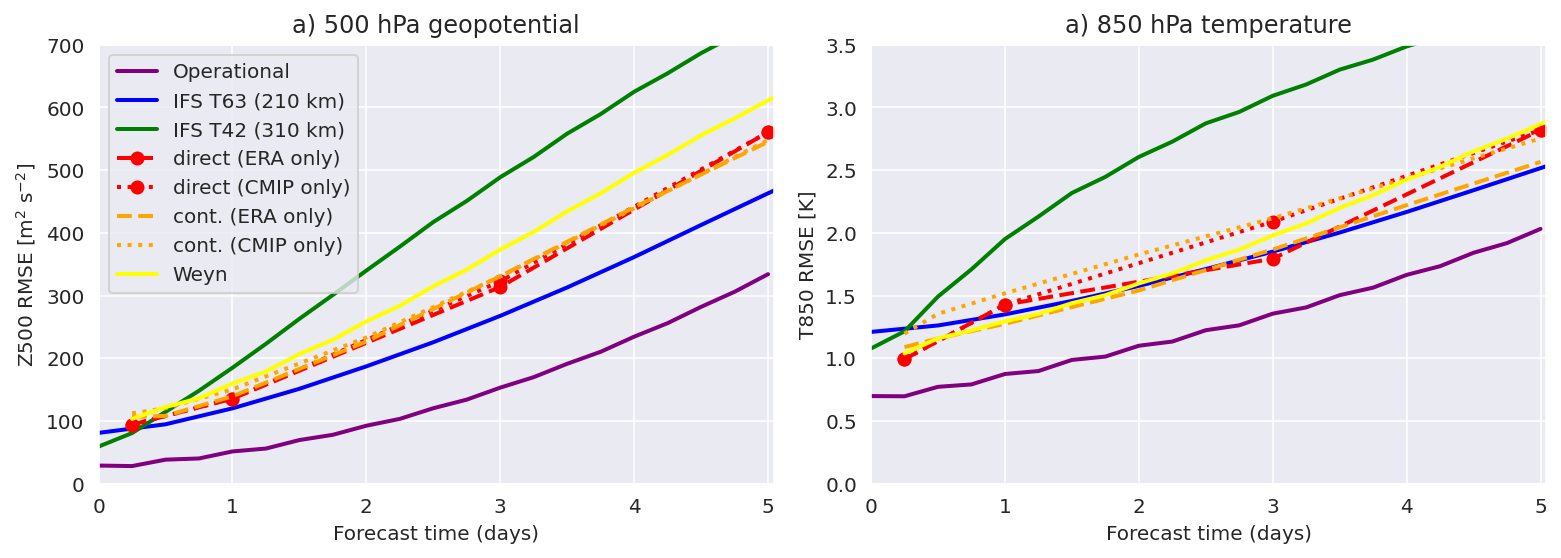

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
plot_zt(rmse_baseline['Operational'], 'Operational', c='purple')
plot_zt(rmse_baseline['IFS T63'], 'IFS T63 (210 km)', c='blue')
plot_zt(rmse_baseline['IFS T42'], 'IFS T42 (310 km)', c='green')
plot_zt(rmse_direct_era, 'direct (ERA only)', c='r', marker='o', ls='--')
plot_zt(rmse_direct_cmip_train, 'direct (CMIP only)', c='r', marker='o', ls=':')
# plot_zt(rmse_direct_pre, 'direct (pretrained)', c='r', marker='o')
plot_zt(rmse_cont_era, 'cont. (ERA only)', c='orange', ls='--')
plot_zt(rmse_cont_cmip_train, 'cont. (CMIP only)', c='orange', ls=':')
# plot_zt(rmse_cont_pre, 'cont. (pretrained)', c='orange')
plot_zt(rmse_weyn, 'Weyn', c='yellow')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')
ax1.set_ylim(0, 700)
ax1.set_title('a) 500 hPa geopotential')
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax2.set_ylim(0, 3.5)
ax2.set_title('a) 850 hPa temperature')
ax2.set_ylabel(r'T850 RMSE [K]')
plt.tight_layout()
plt.savefig('./rmse_era_cmip.png', dpi=200, bbox_inches='tight')

In [40]:
def plot4(ds, ds_prec=None, label=None, tp_div=False, **kwargs):
    ds.z.plot(ax=ax1, label=label, lw=2, **kwargs)
    ds.t.plot(ax=ax2, lw=2, **kwargs)
    ds.t2m.plot(ax=ax3, lw=2, **kwargs)
    if not ds_prec is None: 
        if tp_div:
            (ds_prec.tp * 1000).plot(ax=ax4, lw=2, **kwargs)
        else:
            ds_prec.tp.plot(ax=ax4, lw=2, **kwargs)

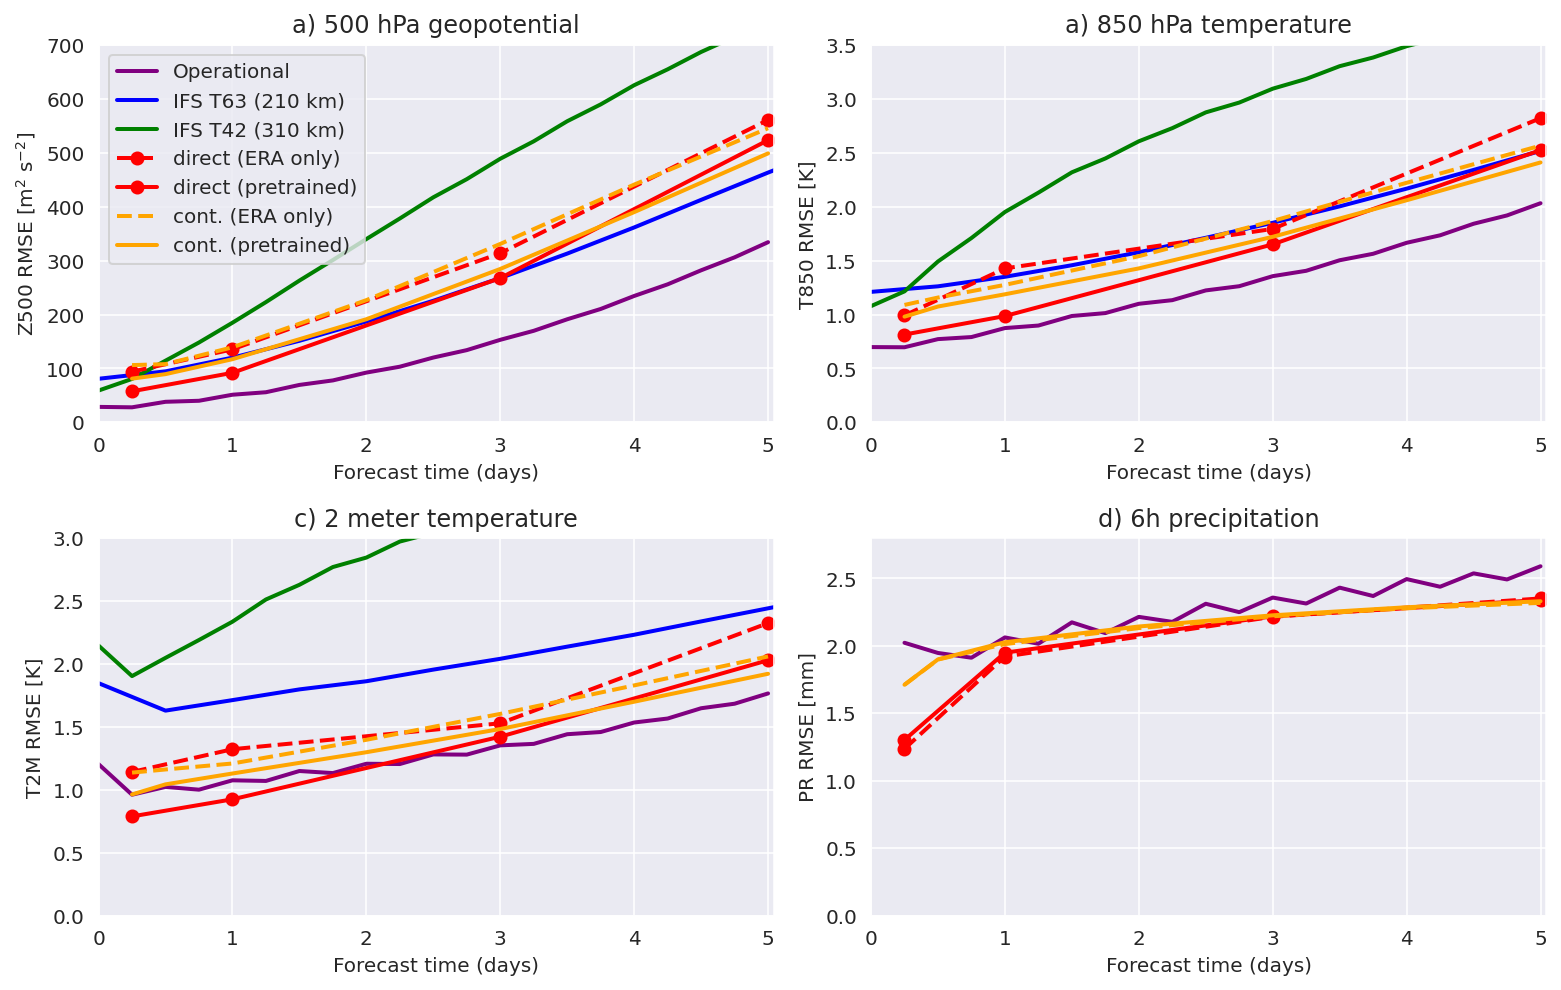

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(11, 7))
((ax1, ax2), (ax3, ax4)) = axs
plot4(rmse_baseline['Operational'], rmse_baseline['Operational'], 'Operational', c='purple', tp_div=True)
plot4(rmse_baseline['IFS T63'], label='IFS T63 (210 km)', c='blue')
plot4(rmse_baseline['IFS T42'], label='IFS T42 (310 km)', c='green')
plot4(rmse_direct_era, rmse_tp_direct_era, 'direct (ERA only)', c='r', marker='o', ls='--', tp_div=True)
plot4(rmse_direct_pre, rmse_tp_direct_pre, 'direct (pretrained)', c='r', marker='o', tp_div=True)
plot4(rmse_cont_era, rmse_tp_cont_era, 'cont. (ERA only)', c='orange', ls='--', tp_div=True)
plot4(rmse_cont_pre, rmse_tp_cont_pre, 'cont. (pretrained)', c='orange', tp_div=True)

ax1.legend()
for ax in axs.flat:
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')


ax1.set_ylim(0, 700)
ax1.set_title('a) 500 hPa geopotential')
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')

ax2.set_ylim(0, 3.5)
ax2.set_title('a) 850 hPa temperature')
ax2.set_ylabel(r'T850 RMSE [K]')

ax3.set_ylim(0, 3)
ax3.set_title('c) 2 meter temperature')
ax3.set_ylabel(r'T2M RMSE [K]')

ax4.set_ylim(0, 2.8)
ax4.set_title('d) 6h precipitation')
ax4.set_ylabel(r'PR RMSE [mm]')

plt.tight_layout()
plt.savefig('rmse.png', dpi=200, bbox_inches='tight')

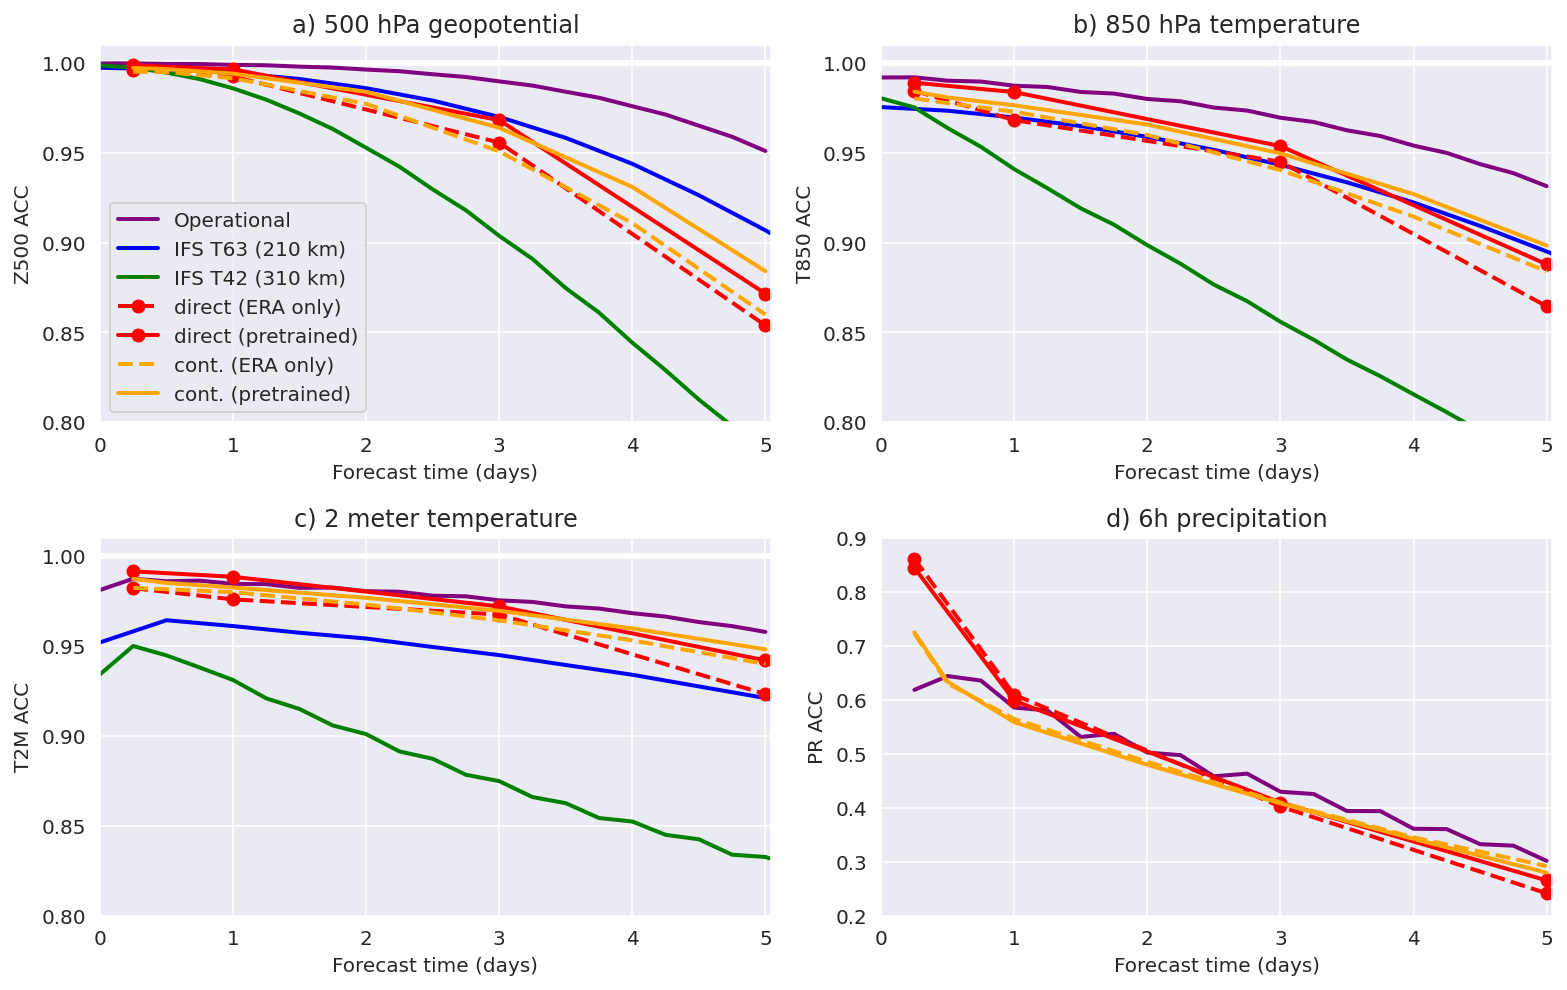

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(11, 7))
((ax1, ax2), (ax3, ax4)) = axs
plot4(acc_baseline['Operational'], acc_baseline['Operational'], 'Operational', c='purple')
plot4(acc_baseline['IFS T63'], label='IFS T63 (210 km)', c='blue')
plot4(acc_baseline['IFS T42'], label='IFS T42 (310 km)', c='green')
plot4(acc_direct_era, acc_tp_direct_era, 'direct (ERA only)', c='r', marker='o', ls='--')
plot4(acc_direct_pre, acc_tp_direct_pre, 'direct (pretrained)', c='r', marker='o')
plot4(acc_cont_era, acc_tp_cont_era, 'cont. (ERA only)', c='orange', ls='--')
plot4(acc_cont_pre, acc_tp_cont_pre, 'cont. (pretrained)', c='orange')

ax1.legend()
for ax in axs.flat:
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')


ax1.set_ylim(0.8, 1.01)
ax1.axhline(1, c='white', lw=3, zorder=0.1)
ax1.set_title('a) 500 hPa geopotential')
ax1.set_ylabel(r'Z500 ACC')
ax1.set_yticks(np.arange(0.8, 1.01, 0.05))

ax2.set_ylim(0.8, 1.01)
ax2.axhline(1, c='white', lw=3, zorder=0.1)
ax2.set_title('b) 850 hPa temperature')
ax2.set_ylabel(r'T850 ACC')
ax2.set_yticks(np.arange(0.8, 1.01, 0.05))

ax3.set_ylim(0.8, 1.01)
ax3.axhline(1, c='white', lw=3, zorder=0.1)
ax3.set_title('c) 2 meter temperature')
ax3.set_ylabel(r'T2M ACC')
ax3.set_yticks(np.arange(0.8, 1.01, 0.05))

ax4.set_ylim(0.2, 0.9)
ax4.axhline(1, c='white', lw=3, zorder=0.1)
ax4.set_title('d) 6h precipitation')
ax4.set_ylabel(r'PR ACC')

plt.tight_layout()
plt.savefig('acc.png', dpi=200, bbox_inches='tight')

#### Scores for tables

In [14]:
def print_scores(ds, ds_tp, label, acc=False):
    dss = xr.merge([ds, ds_tp]).copy(deep=True)
    l3s, l5s=[], []
    for v in ['z', 't', 't2m', 'tp']:
        da = dss[v]
        try:
            l3 = da.sel(concat_dim=72).values
            l5 = da.sel(concat_dim=120).values
        except:
            l3 = da.sel(lead_time=72).values
            l5 = da.sel(lead_time=120).values
        if v=='tp' and not acc:
            l3*=1000
            l5*=1000
        l3s.append(l3)
        l5s.append(l5)
    if acc:
        s = '{:01.2f} / {:01.2f} & {:01.2f} / {:01.2f} & {:01.2f} / {:01.2f} & {:01.2f} / {:01.2f}'.format(
            l3s[0], l5s[0], l3s[1], l5s[1], l3s[2], l5s[2], l3s[3], l5s[3]
        )
    else:
        s = '{:03.0f} / {:03.0f} & {:01.2f} / {:01.2f} & {:01.2f} / {:01.2f} & {:01.2f} / {:01.2f}'.format(
            l3s[0], l5s[0], l3s[1], l5s[1], l3s[2], l5s[2], l3s[3], l5s[3]
        )
    print(s)
    

In [217]:
print_scores(rmse_direct_era, rmse_tp_direct_era, 'direct (ERA only)')

314 / 561 & 1.79 / 2.82 & 1.53 / 2.32 & 2.03 / 2.35


In [218]:
print_scores(rmse_direct_cmip_train, rmse_tp_direct_cmip_train, 'direct (CMIP only)')

323 / 561 & 2.09 / 2.82 & 1.90 / 2.32 & 2.30 / 2.39


In [219]:
print_scores(rmse_direct_pre, rmse_tp_direct_pre, 'direct (pretrained)')

268 / 523 & 1.65 / 2.52 & 1.42 / 2.03 & 2.16 / 2.30


In [262]:
print_scores(rmse_cont_era, rmse_tp_cont_era, 'cont. (ERA only)')

331 / 545 & 1.87 / 2.57 & 1.60 / 2.06 & 2.22 / 2.32


In [275]:
print_scores(rmse_cont_cmip_train, rmse_tp_cont_cmip_train, 'cont. (CMIP only)')

330 / 548 & 2.12 / 2.75 & 2.24 / 2.59 & 2.29 / 2.38


In [264]:
print_scores(rmse_cont_pre, rmse_tp_cont_pre,  'cont. (pretrained)')

284 / 499 & 1.72 / 2.41 & 1.48 / 1.92 & 2.23 / 2.33


In [265]:
print_scores(acc_direct_era, acc_tp_direct_era, 'direct (ERA only)', acc=True)

0.96 / 0.85 & 0.94 / 0.86 & 0.97 / 0.92 & 0.55 / 0.24


In [25]:
print_scores(acc_direct_cmip_train, acc_tp_direct_cmip_train, 'direct (CMIP only)', acc=True)

0.95 / 0.85 & 0.93 / 0.86 & 0.95 / 0.92 & 0.32 / 0.20


In [267]:
print_scores(acc_direct_pre, acc_tp_direct_pre, 'direct (pretrained)', acc=True)

0.97 / 0.87 & 0.95 / 0.89 & 0.97 / 0.94 & 0.45 / 0.29


In [268]:
print_scores(acc_cont_era, acc_tp_cont_era, 'cont. (ERA only)', acc=True)

0.95 / 0.86 & 0.94 / 0.88 & 0.96 / 0.94 & 0.41 / 0.29


In [269]:
print_scores(acc_cont_cmip_train, acc_tp_cont_cmip_train, 'cont. (CMIP only)', acc=True)

0.95 / 0.86 & 0.93 / 0.87 & 0.93 / 0.91 & 0.41 / 0.29


In [270]:
print_scores(acc_cont_pre, acc_tp_cont_pre,  'cont. (pretrained)', acc=True)

0.96 / 0.88 & 0.95 / 0.90 & 0.97 / 0.95 & 0.41 / 0.28


## generalization error

In [98]:
gen_direct_era = (rmse_direct_era - rmse_direct_era_train)
gen_cont_era = (rmse_cont_era - rmse_cont_era_train)
gen_direct_pre = (rmse_direct_pre - rmse_direct_pre_train)
gen_cont_pre = (rmse_cont_pre - rmse_cont_pre_train)

gen_direct_era_rel = (rmse_direct_era - rmse_direct_era_train) / (rmse_direct_era + rmse_direct_era_train) / 2
gen_cont_era_rel = (rmse_cont_era - rmse_cont_era_train) / (rmse_cont_era + rmse_cont_era_train) / 2
gen_direct_pre_rel = (rmse_direct_pre - rmse_direct_pre_train) / (rmse_direct_pre + rmse_direct_pre_train) / 2
gen_cont_pre_rel = (rmse_cont_pre - rmse_cont_pre_train) / (rmse_cont_pre + rmse_cont_pre_train) / 2

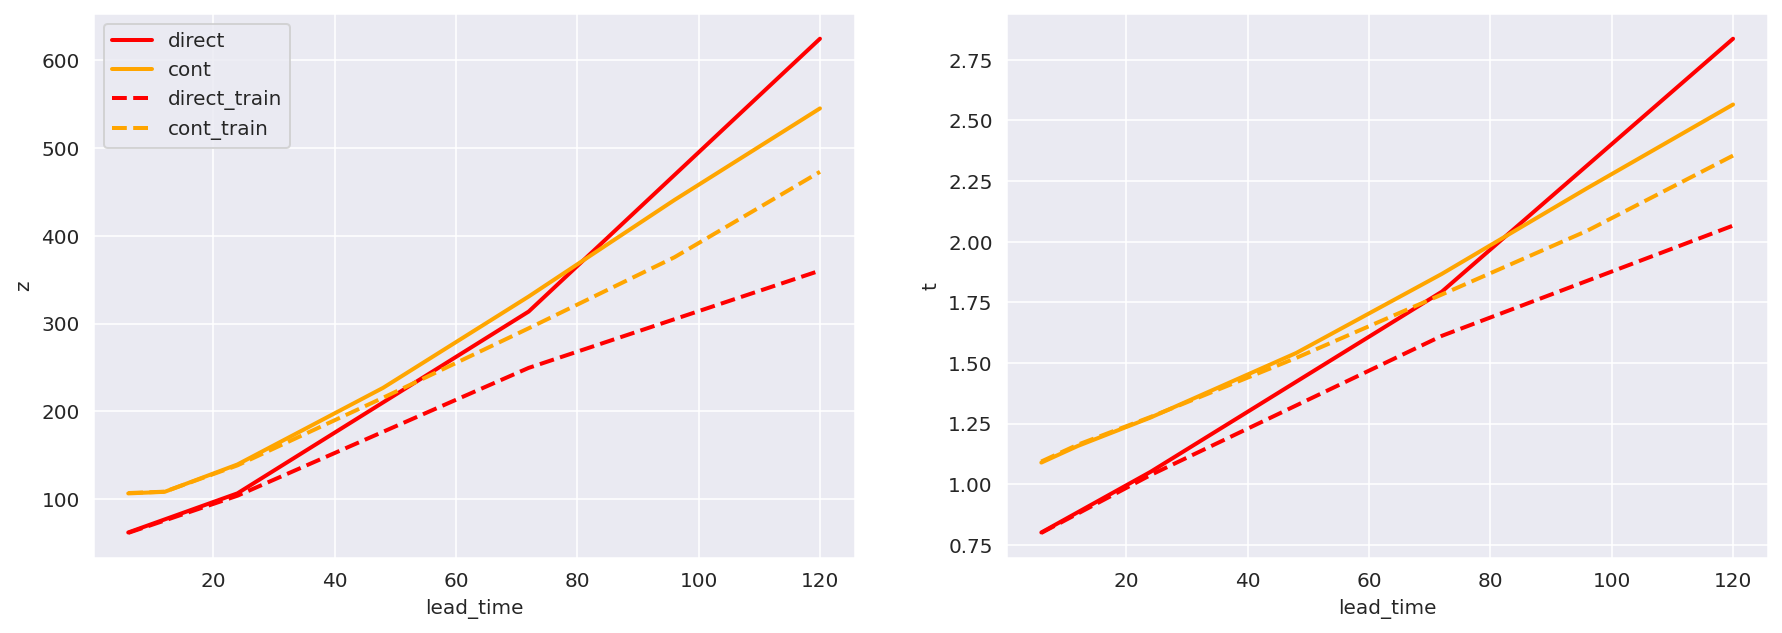

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct_era, 'direct', c='r')
plot_zt(rmse_cont_era, 'cont', c='orange')
plot_zt(rmse_direct_era_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_era_train, 'cont_train', c='orange', ls='--')
ax1.legend()

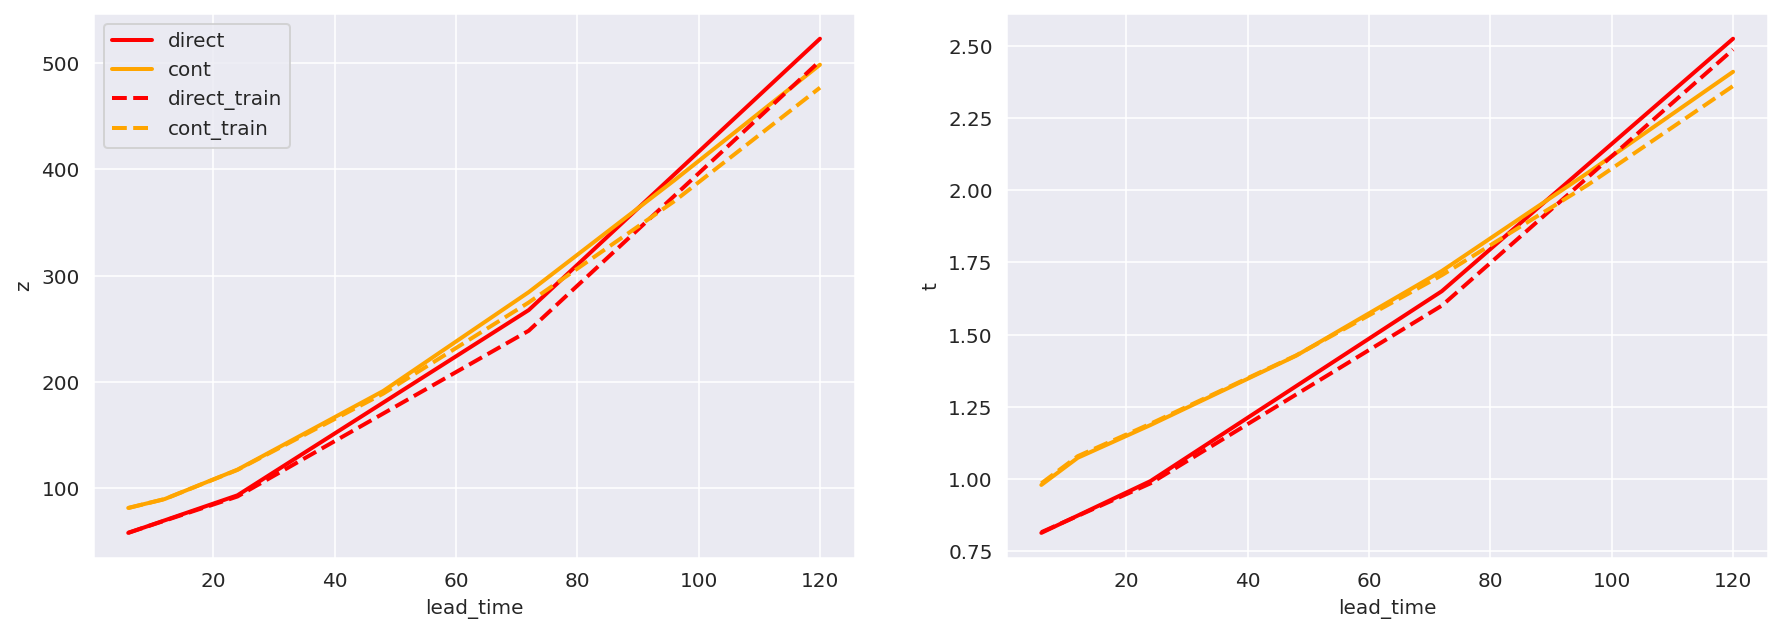

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct_pre, 'direct', c='r')
plot_zt(rmse_cont_pre, 'cont', c='orange')
plot_zt(rmse_direct_pre_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_pre_train, 'cont_train', c='orange', ls='--')
ax1.legend()

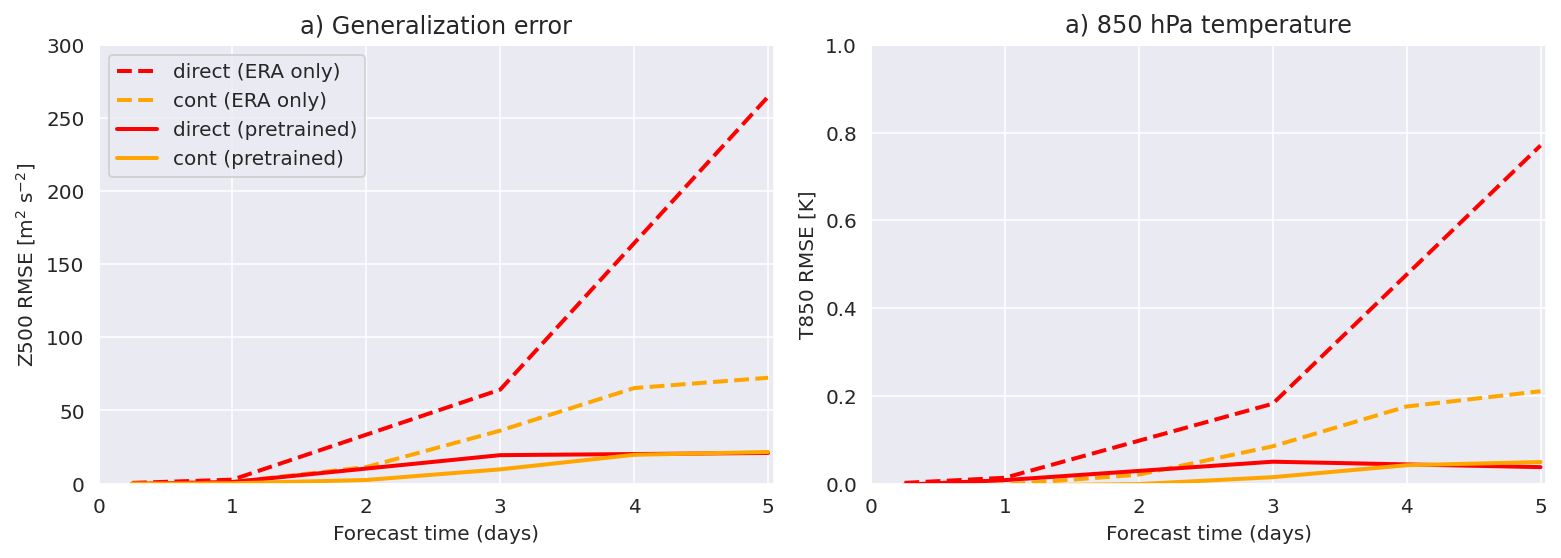

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
plot_zt(gen_direct_era, 'direct (ERA only)', c='r', ls='--')
plot_zt(gen_cont_era, 'cont (ERA only)', c='orange', ls='--')
plot_zt(gen_direct_pre, 'direct (pretrained)', c='r')
plot_zt(gen_cont_pre, 'cont (pretrained)', c='orange')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')
ax1.set_ylim(0, 300)
ax1.set_title('a) Generalization error')
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax2.set_ylim(0, 1)
ax2.set_title('a) 850 hPa temperature')
ax2.set_ylabel(r'T850 RMSE [K]')
plt.tight_layout()

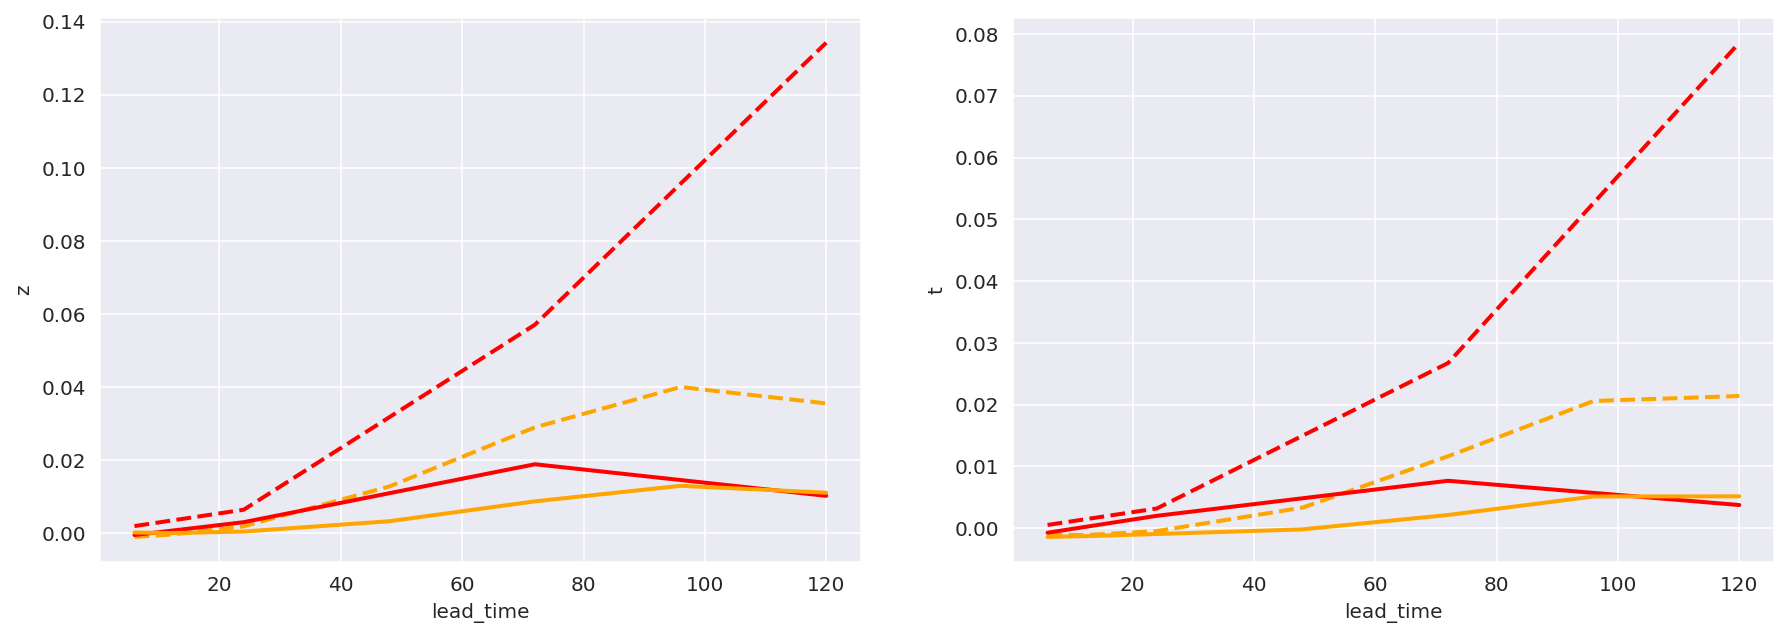

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct_era_rel, 'direct era', c='r', ls='--')
plot_zt(gen_cont_era_rel, 'cont_era', c='orange', ls='--')
plot_zt(gen_direct_pre_rel, 'direct pre', c='r')
plot_zt(gen_cont_pre_rel, 'cont_pre', c='orange')

## 11/22 deg

### Saved test scores

In [102]:
rmse_11_era = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/060-resnet_d3_ztt_3d_11deg.nc'),
    valid
).load()
rmse_22_era = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/061-resnet_d3_ztt_3d_22deg.nc'),
    valid
).load()

In [103]:
rmse_11_pre = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/064-resnet_d3_ztt_3d_11deg_pre.nc'),
    valid
).load()
rmse_22_pre = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/065-resnet_d3_ztt_3d_22deg_pre.nc'),
    valid
).load()

In [113]:
valid_22 = regrid(valid, 22.5)

Reuse existing file: bilinear_32x64_8x16_peri.nc
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


/home/rasp/miniconda3/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [147]:
def coarse_score(exp_id):
    args = load_args(f'../nn_configs/C/{exp_id}.yml')
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    dg_test = load_data(**args, only_test=True)
    model = load_model(args)
    preds = create_predictions(model, dg_test)
    if not len(preds.lat) == 8:
        preds = regrid(preds, 22.5)
    return compute_weighted_rmse(preds, valid_22)

In [148]:
coarse_rmse_11_era = coarse_score('060-resnet_d3_ztt_3d_11deg')
coarse_rmse_22_era = coarse_score('061-resnet_d3_ztt_3d_22deg')
coarse_rmse_11_pre = coarse_score('064-resnet_d3_ztt_3d_11deg_pre')
coarse_rmse_22_pre = coarse_score('065-resnet_d3_ztt_3d_22deg_pre')

Reuse existing file: bilinear_16x32_8x16_peri.nc
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable 

In [149]:
coarse_rmse_5_era = compute_weighted_rmse(
    regrid(
        xr.open_dataset(f'{preddir}/017-resnet_d3_ztt_3d.nc'), 22.5
    ), valid_22
)
coarse_rmse_5_pre = compute_weighted_rmse(
    regrid(
        xr.open_dataset(f'{preddir}/023-resnet_d3_ztt_3d_pre_no_dr.nc'), 22.5
    ), valid_22
)

Reuse existing file: bilinear_32x64_8x16_peri.nc
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') f

In [177]:
coarse_rmse_11_era.to_netcdf('coarse_rmse_11_era.nc')
coarse_rmse_22_era.to_netcdf('coarse_rmse_22_era.nc')
coarse_rmse_11_pre.to_netcdf('coarse_rmse_11_pre.nc')
coarse_rmse_22_pre.to_netcdf('coarse_rmse_22_pre.nc')
coarse_rmse_5_era.to_netcdf('coarse_rmse_5_era.nc')
coarse_rmse_5_pre.to_netcdf('coarse_rmse_5_pre.nc')

In [100]:
coarse_rmse_11_era = xr.open_dataset('coarse_rmse_11_era.nc')
coarse_rmse_22_era = xr.open_dataset('coarse_rmse_22_era.nc')
coarse_rmse_11_pre = xr.open_dataset('coarse_rmse_11_pre.nc')
coarse_rmse_22_pre = xr.open_dataset('coarse_rmse_22_pre.nc')
coarse_rmse_5_era = xr.open_dataset('coarse_rmse_5_era.nc')
coarse_rmse_5_pre = xr.open_dataset('coarse_rmse_5_pre.nc')

In [63]:
rmse_direct_pre.sel(concat_dim=72).z.values, rmse_direct_era.sel(concat_dim=72).z.values

(array(267.55041697), array(313.67628498))

In [60]:
rmse_11_pre.z.values, rmse_11_era.z.values

(array(403.3908897), array(427.84309833))

In [61]:
rmse_22_pre.z.values, rmse_22_era.z.values

(array(677.22360515), array(687.59898781))

In [64]:
np.array([
    [rmse_direct_era.sel(concat_dim=72).z.values, rmse_direct_pre.sel(concat_dim=72).z.values],
    [rmse_11_era.z.values, rmse_11_pre.z.values],
    [rmse_22_era.z.values, rmse_22_pre.z.values]
])

array([[313.67628498, 267.55041697],
       [427.84309833, 403.3908897 ],
       [687.59898781, 677.22360515]])

In [104]:
df = pd.DataFrame(
    data = np.array([
    [rmse_direct_era.sel(concat_dim=72).z.values, rmse_direct_pre.sel(concat_dim=72).z.values],
    [rmse_11_era.z.values, rmse_11_pre.z.values],
    [rmse_22_era.z.values, rmse_22_pre.z.values]
]),
    index=['5.625', '11.25', '22.5'], columns=['ERA only', 'pretrained']
)

Text(0.5, 1.0, 'b) Scaling of error with training resolution')

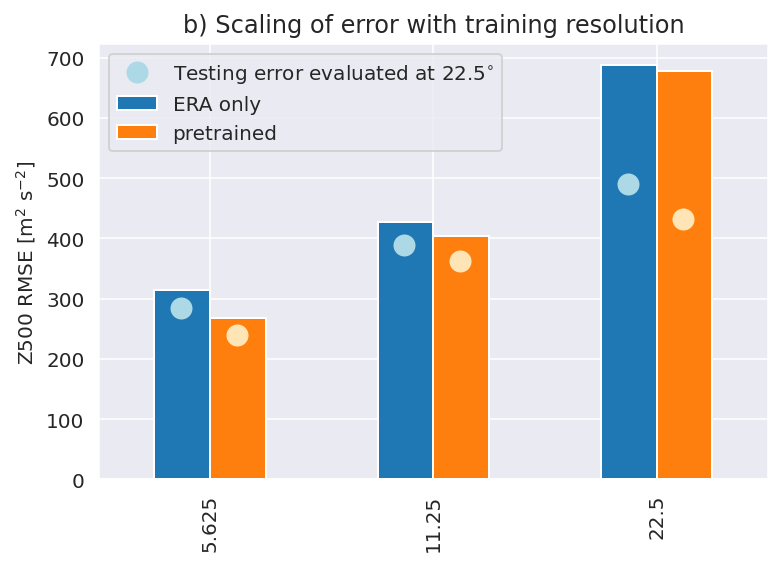

In [105]:
df.plot.bar()
plt.plot(
    np.arange(3)-0.13, 
    [coarse_rmse_5_era.z.values, coarse_rmse_11_era.z.values, coarse_rmse_22_era.z.values], 
    c='lightblue', lw=0, marker='.', markersize=20, label=r'Testing error evaluated at 22.5$^{\circ}$')
plt.plot(
    np.arange(3)+0.12, 
    [coarse_rmse_5_pre.z.values, coarse_rmse_11_pre.z.values, coarse_rmse_22_pre.z.values], 
    c='moccasin', lw=0, marker='.', markersize=20)

plt.legend()
plt.ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
plt.title('b) Scaling of error with training resolution')

## Architecture

In [164]:
rmse_depth = get_direct_scores_from_nc(['017', '066', '067', '068'], [19, 14, 9, 4])

In [173]:
rmse_depth_train = get_direct_scores_from_dg(['017', '066', '067', '068'], [19, 14, 9, 4])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

periodic_conv2d_21 (PeriodicCon (None, 32, 64, 128)  147584      add_9[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 32, 64, 128)  0           periodic_conv2d_21[0][0]         
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 64, 128)  512         leaky_re_lu_21[0][0]             
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 32, 64, 128)  0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
periodic_conv2d_22 (PeriodicCon (None, 32, 64, 128)  147584      dropout_21[0][0]                 
__________________________________________________________________________________________________
leaky_re_l

DG start 16:12:49.582576
DG normalize 16:12:49.627444
DG load 16:12:49.635821
Loading data into RAM
DG done 16:19:10.028785
545/545 [==============================] - 86s 158ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
______________

Load data
DG start 16:32:16.927527
DG normalize 16:32:17.171360
DG load 16:32:17.285233
Loading data into RAM
DG done 16:41:40.740836
545/545 [==============================] - 69s 127ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//066-resnet_d2_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
____

DG start 16:58:30.344260
DG normalize 16:58:30.569498
DG load 16:58:30.588984
Loading data into RAM
DG done 17:07:03.572840
545/545 [==============================] - 69s 126ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//067-resnet_d1_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
______________

DG start 17:17:32.260695
DG normalize 17:17:32.466936
DG load 17:17:32.476850
Loading data into RAM
DG done 17:24:58.809318
545/545 [==============================] - 70s 128ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//068-resnet_d0_ztt_3d_train.nc



In [127]:
rmse_channels = get_direct_scores_from_dg(['017', '069', '070', '071'], [128, 64, 32, 16], split='test')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

545/545 [==============================] - 54s 100ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_test.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 64)   366976      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 64)   0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3

545/545 [==============================] - 55s 100ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//069-resnet_d3_c64_ztt_3d_test.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 32)   183488      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 32)   0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (Non

545/545 [==============================] - 53s 97ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//070-resnet_d3_c32_ztt_3d_test.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 16)   91744       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 16)   0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None

545/545 [==============================] - 53s 97ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//071-resnet_d3_c16_ztt_3d_test.nc



In [119]:
rmse_channels_train = get_direct_scores_from_dg(['017', '069', '070', '071'], [128, 64, 32, 16])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

DG start 21:20:05.700727
DG normalize 21:20:05.747134
DG load 21:20:05.755125
Loading data into RAM
DG done 21:20:23.455896
545/545 [==============================] - 56s 103ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 64)   366976      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 64)   0           periodic_conv2d[0][0]            
______________

DG start 21:21:55.937675
DG normalize 21:21:55.985858
DG load 21:21:55.994473
Loading data into RAM
DG done 21:22:12.102149
545/545 [==============================] - 54s 100ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//069-resnet_d3_c64_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 32)   183488      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 32)   0           periodic_conv2d[0][0]            
__________

DG start 21:23:41.277718
DG normalize 21:23:41.323112
DG load 21:23:41.331146
Loading data into RAM
DG done 21:23:56.867403
545/545 [==============================] - 53s 97ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//070-resnet_d3_c32_ztt_3d_train.nc
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 16)   91744       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 16)   0           periodic_conv2d[0][0]            
___________

DG start 21:25:24.561807
DG normalize 21:25:24.603481
DG load 21:25:24.611574
Loading data into RAM
DG done 21:25:40.691808
545/545 [==============================] - 53s 97ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//071-resnet_d3_c16_ztt_3d_train.nc



In [130]:
# rmse_depth.to_netcdf('rmse_depth.nc')
# rmse_depth_train.to_netcdf('rmse_depth_train.nc')
rmse_channels.to_netcdf('rmse_channels.nc')
rmse_channels_train.to_netcdf('rmse_channels_train.nc')

In [94]:
rmse_depth = xr.open_dataset('rmse_depth.nc')
rmse_depth_train = xr.open_dataset('rmse_depth_train.nc')
rmse_channels = xr.open_dataset('rmse_channels.nc')
rmse_channels_train = xr.open_dataset('rmse_channels_train.nc')

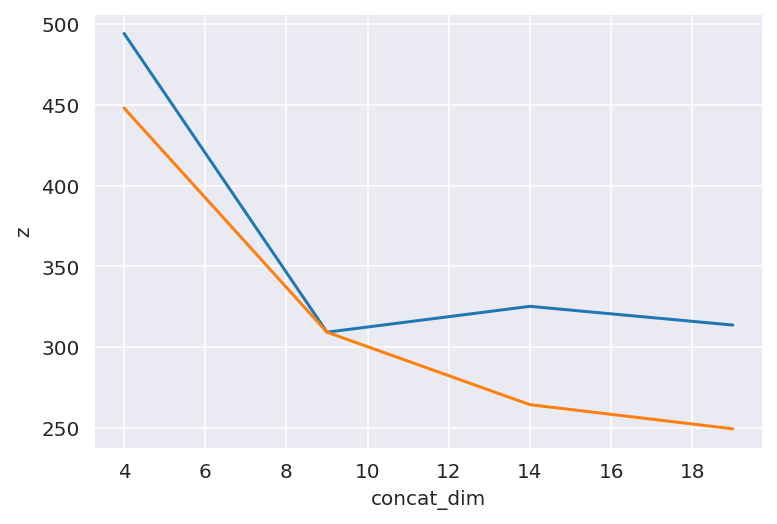

In [95]:
rmse_depth.z.plot()
rmse_depth_train.z.plot()

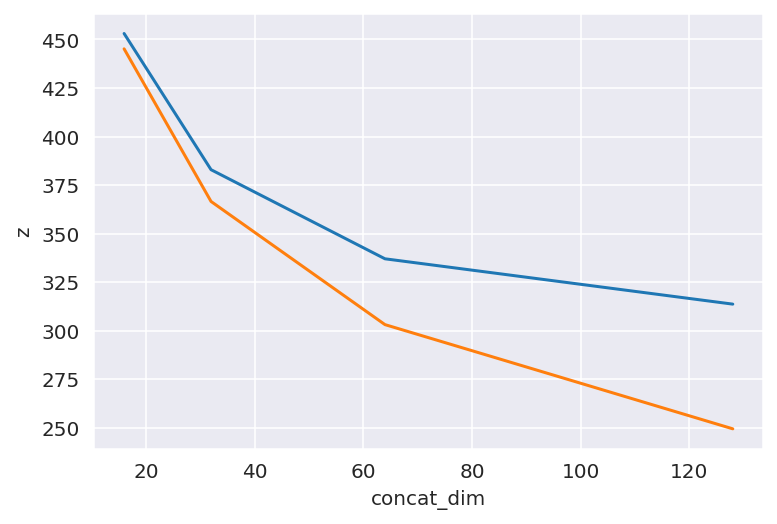

In [131]:
rmse_channels.z.plot()
rmse_channels_train.z.plot()

## Figure for paper

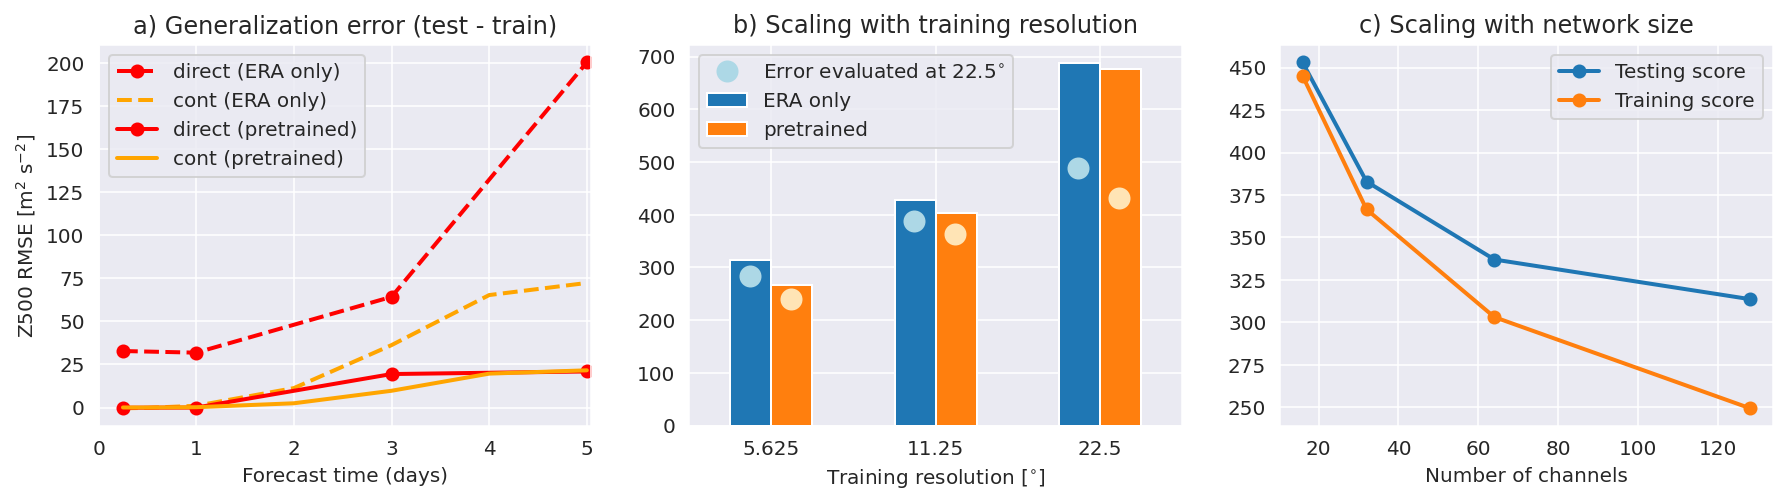

In [134]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3.5))

gen_direct_era.z.plot(ax=ax1, label='direct (ERA only)', c='r', ls='--', lw=2, marker='o')
gen_cont_era.z.plot(ax=ax1, label='cont (ERA only)', c='orange', ls='--', lw=2)
gen_direct_pre.z.plot(ax=ax1, label='direct (pretrained)', c='r', lw=2, marker='o')
gen_cont_pre.z.plot(ax=ax1, label='cont (pretrained)', c='orange', lw=2)
ax1.legend()
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax1.set_title('a) Generalization error (test - train)')
ax1.set_xlim(0, 121)
ax1.set_xticks([0, 24, 48, 72, 96, 120])
ax1.set_xticklabels([0, 1, 2, 3, 4, 5])
ax1.set_xlabel('Forecast time (days)')


df.plot.bar(ax=ax2)
ax2.plot(
    np.arange(3)-0.13, 
    [coarse_rmse_5_era.z.values, coarse_rmse_11_era.z.values, coarse_rmse_22_era.z.values], 
    c='lightblue', lw=0, marker='.', markersize=20, label=r'Error evaluated at 22.5$^{\circ}$')
ax2.plot(
    np.arange(3)+0.12, 
    [coarse_rmse_5_pre.z.values, coarse_rmse_11_pre.z.values, coarse_rmse_22_pre.z.values], 
    c='moccasin', lw=0, marker='.', markersize=20)

ax2.legend()
# ax2.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax2.set_title('b) Scaling with training resolution')
ax2.set_xlabel(r'Training resolution [$^{\circ}$]')
ax2.set_xticklabels([5.625, 11.25, 22.5], rotation=0)


rmse_channels.z.plot(ax=ax3, lw=2, marker='o', label='Testing score')
rmse_channels_train.z.plot(ax=ax3, lw=2, marker='o', label='Training score')
ax3.legend()
# ax2.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax3.set_title('c) Scaling with network size')
ax3.set_xlabel('Number of channels')
ax3.set_ylabel('')

plt.savefig('sensitivity.png', dpi=200, bbox_inches='tight')

In [114]:
rmse_channels.z

<xarray.DataArray 'z' (concat_dim: 4)>
array([313.676285, 303.098599, 382.912274, 453.086129])
Coordinates:
  * concat_dim  (concat_dim) int64 128 64 32 16

In [115]:
rmse_channels_train.z

<xarray.DataArray 'z' (concat_dim: 4)>
array([249.407642, 303.098599, 366.5427  , 445.1871  ])
Coordinates:
  * concat_dim  (concat_dim) int64 128 64 32 16

## Variability

In [73]:
preds_6h = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/026-resnet_d3_ztt_6h_pre_no_dr.nc')
preds_1d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/031-resnet_d3_ztt_1d_pre_no_dr.nc')
preds_3d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/023-resnet_d3_ztt_3d_pre_no_dr.nc')
preds_5d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/034-resnet_d3_ztt_5d_pre_no_dr.nc')

In [80]:
import matplotlib

In [91]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.3, 1, 4))

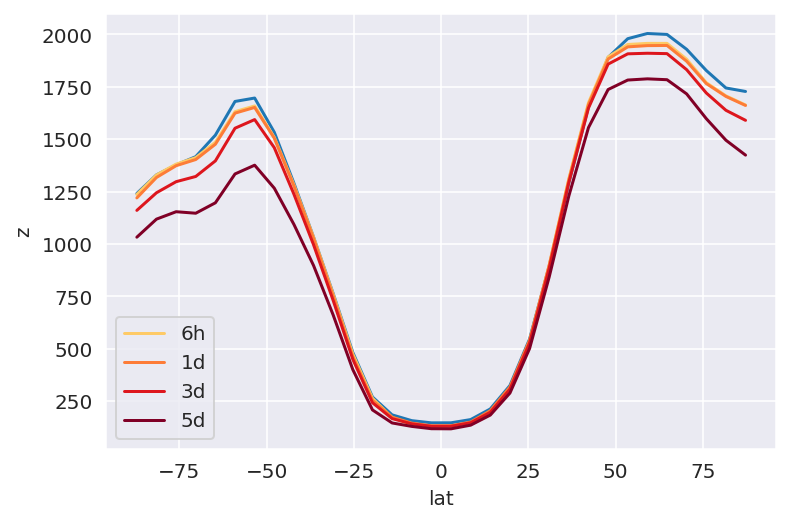

In [108]:
valid.z.std(('lon', 'time')).plot()
preds_6h.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[0], label='6h')
preds_1d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[1], label='1d')
preds_3d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[2], label='3d')
preds_5d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[3], label='5d')
plt.legend()

## Example plots

In [201]:
import cartopy.crs as ccrs

In [216]:
preds_1d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/031-resnet_d3_ztt_1d_pre_no_dr.nc')
preds_3d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/023-resnet_d3_ztt_3d_pre_no_dr.nc')
preds_5d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/034-resnet_d3_ztt_5d_pre_no_dr.nc')
preds_tp_1d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/053-resnet_d3_tp_1d_pre_no_dr.nc')
preds_tp_3d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/056-resnet_d3_tp_3d_pre_no_dr.nc')
preds_tp_5d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/059-resnet_d3_tp_5d_pre_no_dr.nc')

In [248]:
tigge = xr.open_dataset('tigge_5.625deg.nc')

In [264]:
time = '2018-07-01T00'
tigge_time = '2018-06-25T00'

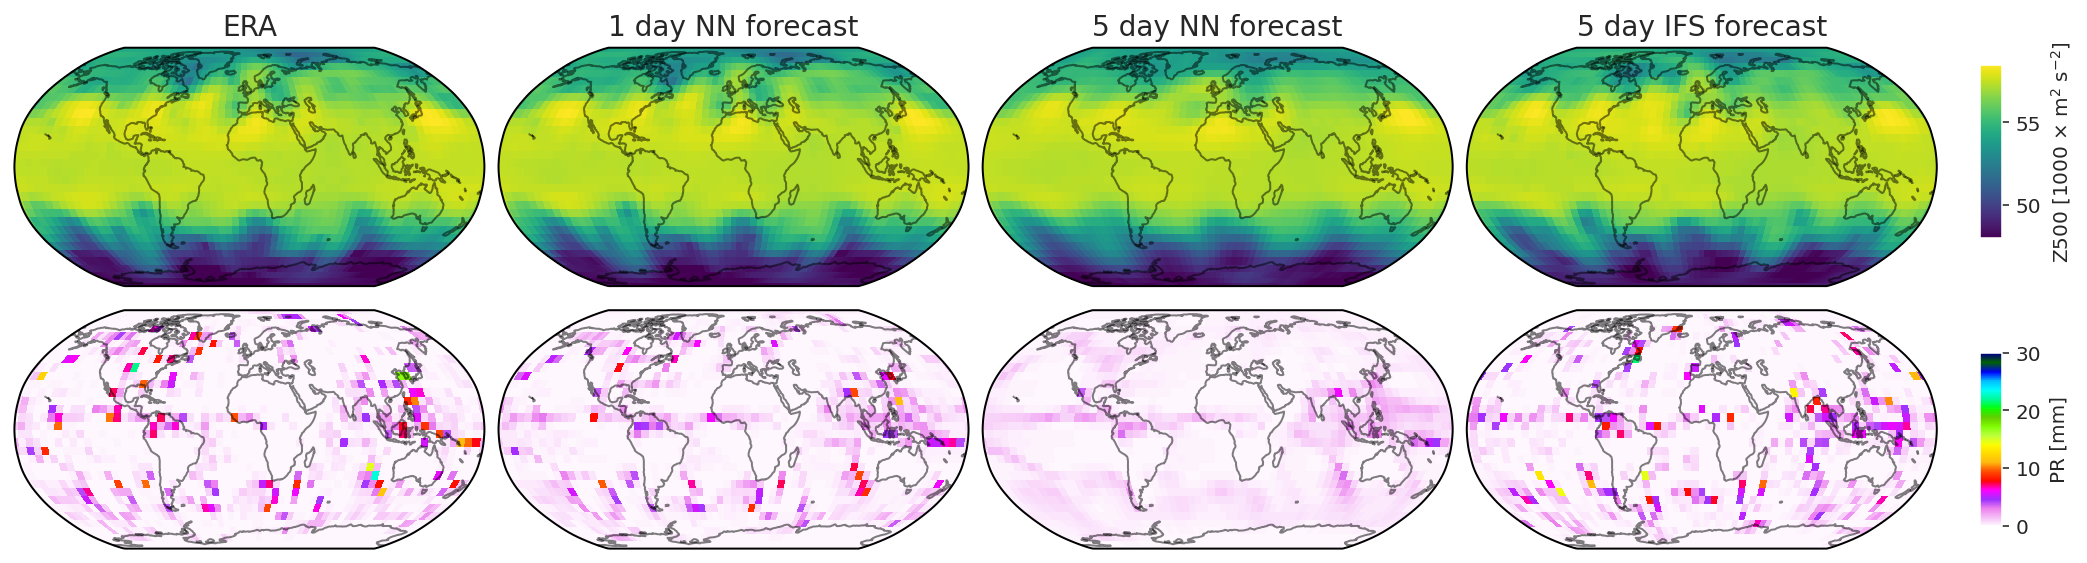

In [278]:
fig, axs = plt.subplots(2, 4, figsize=(15, 4), subplot_kw={'projection': ccrs.Robinson()})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs.flatten()

I = (valid.z.sel(time=time)/1000).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=48, vmax=58.5)
(preds_1d.z.sel(time=time)/1000).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=48, vmax=58.5)
(preds_5d.z.sel(time=time)/1000).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=48, vmax=58.5)
(tigge.z.sel(time=tigge_time, lead_time=120)/1000).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=48, vmax=58.5)
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])
cbar1 = fig.colorbar(I, cax=cax1)
cbar1.set_label(r'Z500 [1000 $\times$ m$^2$ s$^{-2}$]')

I = (valid.tp.sel(time=time)*1000).plot(ax=ax5, vmin=0, vmax=30, cmap='gist_ncar_r', transform=ccrs.PlateCarree(), add_colorbar=False)
(preds_tp_1d.tp.sel(time=time)*1000).plot(ax=ax6, vmin=0, vmax=30, cmap='gist_ncar_r', transform=ccrs.PlateCarree(), add_colorbar=False)
(preds_tp_5d.tp.sel(time=time)*1000).plot(ax=ax7, vmin=0, vmax=30, cmap='gist_ncar_r', transform=ccrs.PlateCarree(), add_colorbar=False)
(tigge.tp.sel(time=tigge_time, lead_time=120)*1000).plot(ax=ax8, vmin=0, vmax=30, cmap='gist_ncar_r', transform=ccrs.PlateCarree(), add_colorbar=False)

cax2 = fig.add_axes([0.92, 0.05, 0.01, 0.3])
cbar2 = fig.colorbar(I, cax=cax2)
cbar2.set_label('PR [mm]')

for ax in axs.flat:
    ax.set_global()
    ax.coastlines(alpha=0.5)
    ax.set_title('')
    
for ax, l in zip(axs[0], ['ERA', '1 day NN forecast', '5 day NN forecast', '5 day IFS forecast']):
    ax.set_title(l, fontsize=14)
    
# for ax in axs[1:].flat:
#     ax.
    
plt.subplots_adjust(left=0.01, right=0.9, wspace=0.03, hspace=0.1, bottom=0.01)
fig.savefig('example.png', dpi=200, bbox_inches='tight')

## Fluctuations

In [8]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('1979', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('1979', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [9]:
valid = valid.isel(time=slice(0, None, 12))

In [10]:
clim = valid.mean('time')

In [11]:
rmse = compute_weighted_rmse(clim, valid, ['lat', 'lon']).load()

In [16]:
rmse_y = rmse.groupby('time.year').mean()

In [21]:
rel = rmse_y / rmse_y.mean('year')

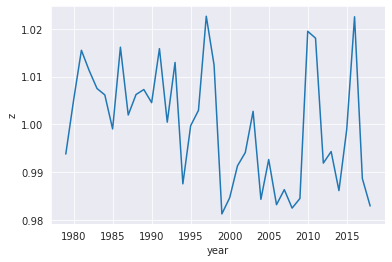

In [22]:
rel.z.plot()

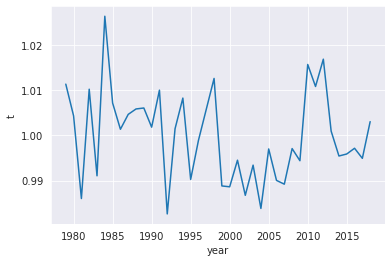

In [23]:
rel.t.plot()

## TP

In [42]:
args = load_args('../nn_configs/C/019-resnet_d3_tp_3d_pre.yml')

In [44]:
dg_test = load_data(**args, only_test=True)

In [45]:
model = load_model(args)

In [47]:
preds = create_predictions(model, dg_test)

ValueError: conflicting sizes for dimension 'level': length 1 on the data but length 4 on coordinate 'level'

In [48]:
%debug

> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(154)_infer_coords_and_dims()
    152                     "conflicting sizes for dimension %r: "
    153                     "length %s on the data but length %s on "
--> 154                     "coordinate %r" % (d, sizes[d], s, k)
    155                 )
    156 

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(343)__init__()
    341             data = _check_data_shape(data, coords, dims)
    342             data = as_compatible_data(data)
--> 343             coords, dims = _infer_coords_and_dims(data.shape, coords, dims)
    344             variable = Variable(dims, data, attrs, fastpath=True)
    345             indexes = dict(

ipdb> u
> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(456)create_predictions()
    454         coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
    455                 'level': level,
--> 456      

## Difference

In [71]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2017', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2017', '2018', None)).drop('level')
t2m_valid = xr.open_mfdataset(f'{valdir}2m_temperature/*.nc').sel(time=slice('2017', '2018', None))
valid = xr.merge([z500_valid, t850_valid, t2m_valid]).load()

In [49]:
args = load_args('../nn_configs/C/027-resnet_d3_ztt_3d_diff.yml')

In [51]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [52]:
dg_test = load_data(**args, only_test=True)

In [56]:
X, y = dg_test[0]

In [53]:
model = load_model(args)

In [109]:
valid.sel(time=dg_test.init_time).assign_coords(time=dg_test.valid_time)

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 50939.312 50954.625 ... 49110.83 49057.234
    t        (time, lat, lon) float32 257.2241 257.20108 ... 255.42131 255.75526
    t2m      (time, lat, lon) float32 248.61656 248.18849 ... 253.59349

In [110]:
pp = valid.sel(time=dg_test.init_time).assign_coords(time=dg_test.valid_time) + preds

In [111]:
compute_weighted_rmse(pp, valid.isel(time=slice(0, None, 12))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 315.2
    t        float64 1.812
    t2m      float64 1.533